# Respiratory Virus Cohort Filtering 
This notebook describes the filtering for a cohort of those with viral respiratory infections. This notebook was copied from the Community Workspace <a href='https://workbench.researchallofus.org/workspaces/aou-rw-ae307fda/respiratoryviralinfectionsinallofus/data'>Respiratory Virus Computable Phenotype</a> on 2025-01-14.

## Import Packages and Codes

In [ ]:
import sys
print(sys.version)

In [ ]:
from IPython.display import display, HTML
from IPython.display import clear_output
import gc
from google.cloud import bigquery
import pandas as pd
import polars as pl
import pyarrow as pa
import os
import subprocess
import numpy as np, scipy as sps
from scipy import stats
import matplotlib, matplotlib.pyplot as plt
# from matplotlib import rcParams
# import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
from datetime import timedelta, datetime as dt
import pytz
from epiweeks import Week, Year

In [ ]:
# This line allows for the plots to be displayed inline in the Jupyter notebook
%matplotlib inline

sns.set(style="ticks",font_scale=1)

In [ ]:
# Define the version of the Curated Data Repository (CDR).
version = %env WORKSPACE_CDR
print("version: " + version)

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')
print("my_bucket: " + my_bucket)

In [ ]:
# show all columns in pandas
pd.set_option("display.max_columns", None)

# show full column width
pd.set_option('display.max_colwidth', 100)

# Polars string length to 100
pl.Config.set_fmt_str_lengths(100)

# Set the row limit to a higher value
pl.Config.set_tbl_rows(50)

In [ ]:
palette = ['#0173b2', '#de8f05', '#8de5a1', '#d55e00', '#029e73', '#cc78bc', '#ece133', 
           '#56b4e9', '#949494', '#fbafe4', '#ca9161']

color_dict = {
    'SARS-CoV-2': '#0173b2',
    'Flu': '#de8f05',
    'RSV': '#8de5a1',
    'RV': '#d55e00',
    'hCoV': '#029e73',
    'hMPV': '#cc78bc',
    'PIV': '#ece133',
    'ADV': '#56b4e9',
    'pert': '#949494',
    'M_pna': '#fbafe4',
    'C_pna': '#ca9161'
}

sns.set_palette(sns.color_palette(palette))
sns.color_palette(palette)

## Helper Functions

In [ ]:
def polars_gbq(query):
    """
    Take a SQL query and return result as polars dataframe
    :param query: BigQuery SQL query
    :return: polars dataframe
    """
    client = bigquery.Client()
    query_job = client.query(query)
    rows = query_job.result()
    df = pl.from_arrow(rows.to_arrow())

    return df

# Load Data

## Load Cohorts

In [ ]:
# DataFrame names
load_names = ['para', 'hMPV', 'RV', 'ADV', 'RSV', 'hCOV', 'Flu', 'COVID']
df_names = ['PIV', 'hMPV', 'RV', 'ADV', 'RSV', 'hCoV', 'Flu', 'SARS-CoV-2']

# Specify data types for columns
dtype_spec = {
    'person_id': 'int64',
    'concept_id': 'int64',
    # 'concept_name': 'object', 'code': 'object', 'vocab': 'object' - No need to specify, default is object
    'visit_id': 'object',  # Changed from float64 to object as per requirements
    'result': 'int64',
    'time_difference': 'float64'
}

# Create an empty list to store the DataFrames
cohort_dfs = []

# Iterate through each filename in the df_names array
for df_name in load_names:
    filename = f"{df_name}.csv"
    
    # Read the CSV file, specifying data types and parsing datetime columns
    df = pd.read_csv(f"{my_bucket}/data/cohorts/icd_only/{filename}", dtype=dtype_spec, parse_dates=['datetime', 'time_zero'])

    df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601', utc=True)
    df['visit_start'] = pd.to_datetime(df['visit_start'], format='ISO8601', utc=True)
    df['time_zero'] = pd.to_datetime(df['time_zero'], format='ISO8601', utc=True)
    
    # Assign DataFrame name
    df.name = df_name

    # Add the DataFrame to the list
    cohort_dfs.append(df)

In [ ]:
cohort_counts_df = []

for df in cohort_dfs:
    # Ensure 'time_zero' and 'datetime' are in datetime format
    df['time_zero'] = pd.to_datetime(df['time_zero'])
    df['visit_start'] = pd.to_datetime(df['visit_start'])
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Drop rows with missing 'time_zero'
    df = df.dropna(subset=['time_zero'])

    # Create dummy variables for 'result' column for each condition
    results_expanded = pd.get_dummies(df['result']).rename(columns={0: 't_inv_count', 1: 't_pos_count', 2: 't_neg_count', 3: 'ICD_count', 4: 'Rx_count'})
    df_expanded = pd.concat([df, results_expanded], axis=1)

    # Ensure all required columns are present, adding 'Rx_count' with zeros if missing
    if 'Rx_count' not in df_expanded.columns:
        df_expanded['Rx_count'] = 0

    # Calculate counts by summing up the dummy variables within groups
    counts_df = df_expanded.groupby(['person_id', 'time_zero'], as_index=False).agg({
        't_inv_count': 'sum',
        't_pos_count': 'sum',
        't_neg_count': 'sum',
        'ICD_count': 'sum',
        'Rx_count': 'sum',
    })

    # Calculate 'mmwr' for each row
    counts_df['mmwr'] = counts_df['time_zero'].apply(lambda x: Week.fromdate(x.date(), system="cdc"))
    
    # Create a mask for datetimes within 14 days from 'time_zero'
    within_14_days_mask = (df['datetime'] <= df['time_zero'] + pd.Timedelta(days=14))
    filtered_df = df.loc[within_14_days_mask]

    # Calculate 'max_visit_acuity' for the filtered DataFrame
    max_visit_acuity_df = filtered_df.groupby(['person_id', 'time_zero'], as_index=False)['visit_acuity'].max().rename(columns={'visit_acuity': 'max_visit_acuity'})

    # Merge the 'max_visit_acuity' DataFrame back into the counts DataFrame
    counts_df = pd.merge(counts_df, max_visit_acuity_df, on=['person_id', 'time_zero'], how='left')

    cohort_counts_df.append(counts_df)

## Aggregate Negative Tests

In [ ]:
# Plot time between repeat negative tests to identify what the most common repeat frequency is
windows = [7, 14, 21, 28]

# Create summary dataframe
summary_df = pd.DataFrame(columns=[f'{w}d' for w in windows])

plot_data = []

# Calculate offset for each virus
n_viruses = len(cohort_dfs)
offset_scale = 2  # Adjust this value to control spread
offsets = np.linspace(-offset_scale, offset_scale, n_viruses)

plt.figure(figsize=(8, 3), dpi=300)

for i, df in enumerate(cohort_dfs):
    df = df.copy()
    df = df[df['test_type'] != 'ag'] #remove Ag results
    df = df[['person_id', 'datetime', 'result', 'time_zero']].drop_duplicates()
    df = df[df['time_zero'].isna()]
    df = df[df['result']==2] #isolate negative results
    
    df = df.sort_values(['person_id', 'datetime'])
    df['time_diff'] = df.groupby('person_id')['datetime'].diff().dt.total_seconds() / (24*60*60)
    df = df[df['time_diff'] <= 365]  # Restrict to 1 year

    # Create 7-day bins
    df['time_diff_bin'] = pd.cut(df['time_diff'], bins=range(0, 372, 7))
    weekly_props = df['time_diff_bin'].value_counts(normalize=True).sort_index()
   
    # Use bin midpoints for x-axis
    bin_midpoints = [(x.left + x.right)/2 + offsets[i] for x in weekly_props.index]
   
    sns.scatterplot(x=bin_midpoints, y=weekly_props.values,
                label=df_names[i],
                color=color_dict[df_names[i]])
    
    total_repeats = len(df[df['time_diff'].notna()])
    props = {}
    for window in windows:
        n_within = len(df[df['time_diff'] <= window])
        props[f'{window}d'] = n_within/total_repeats
          
    summary_df.loc[df_names[i]] = props

plt.xlabel('Days')
plt.ylabel('Proportion of Repeat Tests')
plt.title('Weekly Proportion of Repeat Tests')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 50)
plt.grid(True, alpha=0.3)

# Create tick positions (midpoints) and labels
tick_positions = np.arange(3.5, 50, 7)  # Start at 3.5, increment by 7
tick_labels = np.arange(7, 51, 7)  # Start at 7, increment by 7
plt.xticks(tick_positions, tick_labels)

plt.tight_layout()

print("\nProportion of repeat tests within windows:")
print(summary_df)

In [ ]:
# This aggregates negative test results repeated within 3 weeks
# Copy dfs for processing
processed_dfs = [df.copy() for df in cohort_dfs]

for i, df in enumerate(processed_dfs):
    print(f"Processing virus {df_names[i]}...")
    temp_df = df.copy()

    # Ensure 'time_zero' and 'datetime' are in datetime format
    temp_df['time_zero'] = pd.to_datetime(temp_df['time_zero'])
    temp_df['visit_start'] = pd.to_datetime(temp_df['visit_start'])
    temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])

    # Process rows where time_zero was not set, where the result was not indeterminate (i.e. negative test results)
    process_mask = temp_df['time_zero'].isna() & (temp_df['result']!=0)

    process_df = temp_df[process_mask].copy()
    process_df = process_df.sort_values(['person_id', 'datetime'])

    # Create mask for rows where time_zero is NA and result is 2 (negative)
    # Initialize new column
    df['time_zero_21'] = pd.NaT

    # Initialize new column
    process_df['time_zero_21'] = pd.NaT

    # Process each person's data
    for person_id, person_df in process_df.groupby('person_id'):
        for idx in person_df.index:
            if process_df.loc[idx, 'time_zero_21'] is pd.NaT:
                current_date = process_df.loc[idx, 'datetime']
                next_window = person_df[
                    (person_df['datetime'] > current_date) & 
                    (person_df['datetime'] <= current_date + pd.Timedelta(days=21))
                ]
                if not next_window.empty:
                    process_df.loc[next_window.index, 'time_zero_21'] = current_date
                process_df.loc[idx, 'time_zero_21'] = current_date

    # Update only the processed rows in the original dataframe
    processed_dfs[i].loc[process_mask, 'time_zero'] = process_df['time_zero_21']

print("Done processing all viruses")

In [ ]:
cohort_grouped_test_counts_df = []

for df in processed_dfs:
    # Ensure 'time_zero' and 'datetime' are in datetime format
    df['time_zero'] = pd.to_datetime(df['time_zero'])
    df['visit_start'] = pd.to_datetime(df['visit_start'])
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Create dummy variables for 'result' column for each condition
    results_expanded = pd.get_dummies(df['result']).rename(columns={0: 't_inv_count', 1: 't_pos_count', 2: 't_neg_count', 3: 'ICD_count', 4: 'Rx_count'})
    df_expanded = pd.concat([df, results_expanded], axis=1)

    # Ensure all required columns are present, adding 'Rx_count' with zeros if missing
    if 'Rx_count' not in df_expanded.columns:
        df_expanded['Rx_count'] = 0

    # Calculate counts by summing up the dummy variables within groups
    counts_df = df_expanded.groupby(['person_id', 'time_zero'], as_index=False).agg({
        't_inv_count': 'sum',
        't_pos_count': 'sum',
        't_neg_count': 'sum',
        'ICD_count': 'sum',
        'Rx_count': 'sum',
    })

    cohort_grouped_test_counts_df.append(counts_df)

# Filter

In [ ]:
# filtering to remove ICD-only hCoV cases after 2-1-2020 - these were disrupted by the COVID-19 pandemic
cohort_counts_df[5] = cohort_counts_df[5][
    (cohort_counts_df[5]['time_zero'] <= '2020-02-01') | 
    (cohort_counts_df[5]['t_pos_count'] > 0)
]

# Complete Hospitalization Status

In [ ]:
for df in cohort_counts_df:
    df.loc[:, 'max_visit_acuity'] = df['max_visit_acuity'].fillna(0)

## Assess ER Visits and Hospitalizations

In [ ]:
expanded_palette = {
    'PIV': ['#FCFADE', '#F8F5C3', '#F4F0A2', '#F0E97C', '#F2E969', '#ece133'],
    'hMPV': ['#FAF5FA', '#F3E7F2', '#EED3EA', '#DEBCDB', '#DA9CCE', '#cc78bc'],
    'RV': ['#FAF3ED', '#F4E3D4', '#EBCCB0', '#DFAE83', '#D48C51', '#d55e00'],
    'ADV': ['#F4FAFD', '#DDEAF2', '#CEE6F6', '#B3D8F1', '#92C6EB', '#56b4e9'],
    'RSV': ['#F7FDF8', '#EBFAEE', '#DAF7E0', '#C5F2CF', '#ABECB9', '#8de5a1'],
    'hCoV': ['#EFF8F5', '#D4E9E2', '#B7DFD3', '#8FCAB7', '#66B599', '#029e73'],
    'Flu': ['#FCF7EE', '#F7EBD5', '#F0DCB3', '#E7C789', '#E7AC46', '#de8f05'],
    'Flu w/ Rx': ['#FCF7EE', '#F7EBD5', '#F0DCB3', '#E7C789', '#E7AC46', '#de8f05'],
    'SARS-CoV-2': ['#EEF5F9', '#D6E5F0', '#B4D1E4', '#8AB6D5', '#4398C7', '#0173b2'],
    'SARS-CoV-2 w/ Rx': ['#EEF5F9', '#D6E5F0', '#B4D1E4', '#8AB6D5', '#4398C7', '#0173b2'],
}

In [ ]:
# Concatenate 'person_id' from each DataFrame in the list into one Series
cohort_person_ids_series = pd.concat([df['person_id'] for df in cohort_counts_df]).drop_duplicates()

# Convert the Series to a list and then to a string, with each person_id cast to string if they are not already
cohort_person_ids_str = ', '.join([str(id) for id in cohort_person_ids_series.tolist()])

all_visit_ids_df = []

all_visit_ids = f"""
        SELECT DISTINCT
            v.visit_concept_id,
            c.concept_name AS visit_name
        FROM
            {version}.visit_occurrence v
        LEFT JOIN
            {version}.concept c ON v.visit_concept_id = c.concept_id
        WHERE
            v.person_id IN ({cohort_person_ids_str})
        """

all_visit_ids_df = polars_gbq(all_visit_ids)

In [ ]:
acuity_mapping = {
    5: [8717, 262, 9201, 38004515, 32037, 8920, 38004284, 4313303, 38004311, 8971],  # IP, incl inpatient hospice
    4: [8870, 581385, 9203, 38004354, 4163685, 38004353, 581478, 8668],  # ED, ambulance
    3: [8782], #UC
    2: [38004285, 8676, 42898160, 38004303, 8546],  # facility + hospice
    1: [8858, 8756, 8947, 38004262, 581476, 38004268, 38004259, 581458, 38004267, 38004250, 38004222, 
        38004207, 38004193, 581479, 5083, 32036, 38004696, 38004519, 581475, 38004264, 38004269, 
        38004249, 38004245, 32693, 38004238, 38004251, 8883, 581477, 9202, 38004228, 38004246, 
        38004227, 38004218, 2514528, 2514520, 2514527, 8964, 32261, 4203722, 38004322, 38004258, 
        8966, 38004225, 2514521, 38004362, 38004363, 38004338, 38004247],  # OP
    0: [32209, 8844]  # Unknown
}

# Initialize an expression for the `acuity` column starting with None values
acuity_expr = pl.lit(None)

# Iterate through the mapping to update the expression based on conditions
for acuity_level, visit_ids in acuity_mapping.items():
    acuity_expr = pl.when(pl.col("visit_concept_id").is_in(visit_ids)).then(pl.lit(acuity_level)).otherwise(acuity_expr)

# Ensure the expression is aliased to 'acuity' after the loop, before applying it to the DataFrame
acuity_expr = acuity_expr.alias("acuity")
    
# Apply the mapping to create the new 'acuity' column
all_visit_ids_df = all_visit_ids_df.with_columns(acuity_expr)

In [ ]:
all_visit_ids_df.filter(pl.col('acuity').is_null())

**Determine Max Acuity**

In [ ]:
# Convert Polars DataFrame to a list of dictionaries
rows_list = all_visit_ids_df.to_dicts()

# Generate the SQL snippet
sql_parts = [f"SELECT {row['acuity']} AS acuity_level, {row['visit_concept_id']} AS visit_concept_id" for row in rows_list]
sql_query = " UNION ALL\n            ".join(sql_parts)

# print(sql_query)

In [ ]:
visit_id_df = []

# Query all visits for person_ids in question
max_visit_id = f"""
        WITH acuity_mapping AS (
          {sql_query}
        )
        SELECT DISTINCT
          v.visit_occurrence_id,
          person_id,
          v.visit_concept_id,
          visit_start_date,
          visit_end_date,
          COALESCE(a.acuity_level, -1) AS acuity_level
        FROM
          {version}.visit_occurrence v
        LEFT JOIN
          acuity_mapping a ON v.visit_concept_id = a.visit_concept_id
        WHERE
          v.person_id IN ({cohort_person_ids_str})
        ORDER BY
          v.person_id ASC, visit_start_date ASC, acuity_level DESC
        """

visit_id_df = polars_gbq(max_visit_id)

In [ ]:
visit_id_df = visit_id_df.to_pandas()
visit_id_df['acuity_level'][visit_id_df['acuity_level'].isna()]

In [ ]:
# Determine maximum acuity for each person
# Convert `visit_start_date` in `visit_id_df` to timezone-naive
visit_id_df['visit_start_date'] = visit_id_df['visit_start_date'].dt.tz_localize(None)
visit_id_df['visit_end_date'] = visit_id_df['visit_end_date'].dt.tz_localize(None)

max_acuity_dfs = []

for i, df in enumerate(cohort_counts_df):
    # Convert `time_zero` to datetime if not already, and ensure it's timezone-naive
    df.loc[:, 'time_zero'] = pd.to_datetime(df['time_zero']).dt.tz_localize(None)

    # Merge df with visit_id_df on 'person_id'
    merged_df = pd.merge(df, visit_id_df, on='person_id', how='left')

    # Include rows where visit_start_date is between 7 days before and 14 days after time_zero
    # OR time_zero is between visit_start_date and visit_end_date
    condition = (
        ((merged_df['visit_start_date'] >= merged_df['time_zero'] - pd.Timedelta(days=7)) &
         (merged_df['visit_start_date'] <= merged_df['time_zero'] + pd.Timedelta(days=14))) |
        ((merged_df['time_zero'] >= merged_df['visit_start_date']) &
         (merged_df['time_zero'] <= merged_df['visit_end_date'] + pd.Timedelta(days=1)))
    )
    filtered_df = merged_df[condition]

    # Group by 'person_id' and calculate the maximum 'acuity_level' for each group
    max_acuity_df = filtered_df.groupby('person_id')['acuity_level'].max().reset_index()
    max_acuity_df.rename(columns={'acuity_level': 'max_acuity'}, inplace=True)

    # Merge back to add the 'max_acuity' column to the original df
    cohort_counts_df[i] = pd.merge(df, max_acuity_df, on='person_id', how='left')

### Compare max_acuity and max_visit_name

In [ ]:
for df in cohort_counts_df:
    # Set NaN values in max_acuity and max_visit_name to 0
    df['max_acuity'] = df['max_acuity'].fillna(0)
    df['max_visit_acuity'] = df['max_visit_acuity'].fillna(0)

In [ ]:
# Calculate the total number of rows needed for 3 heatmaps per row
total_dfs = len(cohort_counts_df)
rows_needed = -(-total_dfs // 3)  # Ceiling division to ensure we have enough rows

# Define the new tick labels
label_dict = {
    0: 'unk',
    1: 'OP', 
    2: 'facility', 
    3: 'UC', 
    4: 'ER', 
    5: 'IP'
}

# Set up the figure with subplots
fig, axs = plt.subplots(rows_needed, 3, figsize=(9, 3 * rows_needed), dpi=300)

for i, df in enumerate(cohort_counts_df):
    # Prepare the data: Count the occurrences of each combination of max_visit_name and max_acuity
    heatmap_data = df.groupby(['max_visit_acuity', 'max_acuity']).size().unstack(fill_value=0)
    
    # Create a mask for values between 1 and 19
    mask = (heatmap_data > 0) & (heatmap_data < 20)

    # Create a copy of the data for coloring
    heatmap_data_color = heatmap_data.copy()
    heatmap_data_color[mask] = 1  # Set masked values to 1 for coloring

    # Create a copy of the data for annotation
    heatmap_data_annot = heatmap_data.astype(str)
    heatmap_data_annot[mask] = '<20'

    # Calculate current row and column in the subplot grid
    row, col = divmod(i, 3)
    
    # Get the current axis
    ax = axs[row, col] if rows_needed > 1 else axs[col]
    
    # Create the heatmap in the appropriate subplot
    # Uncomment next line to print cbar
    cbar = False
#     cbar = True if i == len(filtered_cohort_counts_df) - 1 else False
    sns.heatmap(heatmap_data_color, annot=heatmap_data_annot, cmap="YlGnBu", fmt="", cbar=cbar, 
                annot_kws={"size": 7}, ax=ax)
    
    # Set new tick labels
    ax.set_xticklabels([label_dict.get(x, x) for x in heatmap_data.columns])
    ax.set_yticklabels([label_dict.get(y, y) for y in heatmap_data.index])
    
    ax.set_title(f'{df_names[i]}', fontsize=8)
    ax.set_ylabel('Acuity for Phenotyped Components', fontsize=8)
    ax.set_xlabel('Acuity for All EHR Visits', fontsize=8)
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)

# Hide any unused subplots
for j in range(i+1, rows_needed * 3):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
# Initialize an empty list to store temporary DataFrames
temp_dfs = []

for i, df in enumerate(cohort_counts_df):
    # Filter the DataFrame based on the condition max_visit_name > max_acuity
    filtered_df = df[df['max_visit_acuity'] > df['max_acuity']]
    
    # Create a temporary DataFrame with df index, person_id, and time_zero
    temp_df = pd.DataFrame({
        'df': df_names[i],  # DataFrame's index in the list
        'person_id': filtered_df['person_id'],
        'time_zero': filtered_df['time_zero']
    })
    
    # Append the temporary DataFrame to the list
    temp_dfs.append(temp_df)

# Concatenate all temporary DataFrames into a single DataFrame
ehr_greater_than_all = pd.concat(temp_dfs, ignore_index=True)

In [ ]:
# Browse list for those with max_visit_name > max_acuity
ehr_greater_than_all.value_counts('df')

In [ ]:
for i, df in enumerate(cohort_counts_df):
    print(f'{df_names[i]}: {len(df)}')

Manual review of discrepancies (prior study):<br>
<b>0 Parainfluenza:</b> measurement references IP visit from 10 days prior. use measurement<br>
<b>1 hMPV:</b> measurement references IP visits from 9, 7 days prior. use measurement<br>
<b>2 RV:</b> measurement references OP visits from 7 and 2 mo away. use visit<br>
<b>3 ADV:</b> measurement references OP visit a year away. use visit<br>
<b>4 RSV:</b> measurements correct 3/5. use measurement<br>
<b>5 hCoV:</b> no discrepancies<br>
<b>6 flu:</b> measurement wrong 8/8. use visit<br>
<b>7 SARS-CoV-2:</b> measurement wrong 66/74. use visit<br>

## Reconcile Discrepancies

In [ ]:
# List of specific DataFrame indices to update
indices_to_update = [0, 1, 4] #where using measurement

for i in indices_to_update:
    # Access the DataFrame at the current index
    df = cohort_counts_df[i]
    
    # Update max_acuity where max_visit_name > max_acuity
    df.loc[df['max_visit_acuity'] > df['max_acuity'], 'max_acuity'] = df['max_visit_acuity']
    
    # Update the DataFrame in the list
    cohort_counts_df[i] = df

In [ ]:
for df in cohort_counts_df:
    df.loc[:, 'max_acuity'] = df['max_acuity'].fillna(0)
    df.drop(columns=['max_visit_acuity'], inplace=True)

## Visit Breakdown of Completed Hospitalization Status

In [ ]:
def prepare_data(cohort_counts_df, df_names, is_positive_test):
    all_data = []
    for df, name in zip(cohort_counts_df, df_names):
        df_copy = df.copy()
        df_copy = df_copy[df_copy['t_pos_count'] > 0] if is_positive_test else df_copy[df_copy['t_pos_count'] == 0]
        df_copy['df_name'] = name
        all_data.append(df_copy)
        
        if name in ['SARS-CoV-2', 'Flu']:
            df_rx = df.copy()
            condition = (df_rx['t_pos_count'] > 0) if is_positive_test else (df_rx['t_pos_count'] == 0)
            df_rx = df_rx[condition & (df_rx['Rx_count'] > 0)]
            df_rx['df_name'] = f'{name} w/ Rx'
            all_data.append(df_rx)
    
    return pd.concat(all_data)

def process_data(data, df_names):
    acuity_levels = [0, 1, 2, 3, 4, 5]
    all_combinations = pd.MultiIndex.from_product([df_names, acuity_levels], 
                                                  names=['df_name', 'max_acuity'])
    
    data_long = data.groupby(['df_name', 'max_acuity']).size().reset_index(name='count')
    data_long['max_acuity'] = data_long['max_acuity'].astype(int)
    data_long = data_long.set_index(['df_name', 'max_acuity']).reindex(all_combinations, fill_value=0).reset_index()
    data_long = data_long.sort_values(['df_name', 'max_acuity'])
    data_long['cumsum'] = data_long.groupby('df_name')['count'].cumsum()
    
    total_counts = data_long.groupby(['df_name'])['count'].sum().reset_index(name='total')
    data_long = data_long.merge(total_counts, on='df_name')
    data_long['percentage'] = data_long['cumsum'] / data_long['total'] * 100
    data_long['percentage'] = data_long['percentage'].fillna(0)
    
    return data_long
    
# List of dataframes to include
left_dfs = ['RV', 'hMPV', 'RSV', 'ADV', 'PIV', 'hCoV']
right_dfs = ['SARS-CoV-2', 'SARS-CoV-2 w/ Rx', 'Flu', 'Flu w/ Rx']
all_dfs = left_dfs + right_dfs

# Prepare and process the data
test_data = process_data(prepare_data(cohort_counts_df, df_names, is_positive_test=True), all_dfs)
no_test_data = process_data(prepare_data(cohort_counts_df, df_names, is_positive_test=False), all_dfs)
no_test_data[['cumsum', 'percentage']] *= -1

In [ ]:
palette = {'ER': '#4c72b0', 'Inpatient': '#c44e52'}

In [ ]:
def create_stacked_bar_chart(test_data, no_test_data, left_dfs, right_dfs, expanded_palette):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [3, 2]})
    acuity_order = [5, 4, 3, 2, 1, 0]
    bar_width = 0.9
    
    def plot_on_axis(ax, df_list, data, no_data):
        for idx, df_name in enumerate(df_list):
            x = idx

            for i, acuity in enumerate(acuity_order):
                for data_set in [data, no_data]:
                    acuity_data = data_set[(data_set['max_acuity'] == acuity) & 
                                           (data_set['df_name'] == df_name)]
                    value = acuity_data['cumsum'].values
                    if len(value) > 0:
                        ax.bar(x, value[0], width=bar_width, 
                              color=expanded_palette[df_name][acuity], 
                              edgecolor='white', linewidth=0.5,
                              zorder=i)
        
        # Set x-ticks and labels
        ax.set_xticks(np.arange(len(df_list)))
        ax.set_xticklabels(df_list, rotation=45, ha='right')
        
        # Add dataset labels
        ax3 = ax.twiny()
        ax3.set_xticks(np.arange(len(df_list)))
        ax3.set_xticklabels(df_list, rotation=45, ha='left')
        ax3.set_xlim(ax.get_xlim())
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)

        ax.set_ylim(-40000 if ax == ax2 else -3000, 40000 if ax == ax2 else 3000)
        ax.set_ylabel('Count' if ax == ax1 else '')
 
        if ax == ax2:
            ax.text(.97, .75, 'Positive Test', transform=ax.transAxes, rotation=90, va='center', ha='left')
            ax.text(.97, .25, 'No Positive Test', transform=ax.transAxes, rotation=90, va='center', ha='left')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    plot_on_axis(ax1, left_dfs, test_data, no_test_data)
    plot_on_axis(ax2, right_dfs, test_data, no_test_data)
    
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1, zorder=10)
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=1, zorder=10)
    
    acuity_labels = ["IP", "ER", "UC", "Facility", "OP", "Unknown"]
    acuity_patches = [plt.Rectangle((0,0),1,1, fc=expanded_palette['SARS-CoV-2'][5-i]) for i, acuity in enumerate(acuity_order)]
    legend = fig.legend(acuity_patches, acuity_labels, title='Max Visit Acuity', bbox_to_anchor=(1.1, 0.64), loc='upper right')
    
#     legend_elements = [Patch(facecolor=palette[label], edgecolor=palette[label], label=label) for label in palette]
    # Set legend background to white and add edge
    legend.get_frame().set_facecolor('white')
    
    plt.tight_layout()
    plt.show()

# Create the grouped stacked bar chart
create_stacked_bar_chart(test_data, no_test_data, left_dfs, right_dfs, expanded_palette)

In [ ]:
def create_stacked_bar_chart(test_data, no_test_data, all_dfs, expanded_palette):
    fig, ax = plt.subplots(figsize=(15, 10))
    acuity_order = [5, 4, 3, 2, 1, 0]
    bar_width = 0.9
    
    for idx, df_name in enumerate(all_dfs):
        x = idx
        for i, acuity in enumerate(acuity_order):
            for data_set in [test_data, no_test_data]:
                acuity_data = data_set[(data_set['max_acuity'] == acuity) & 
                                       (data_set['df_name'] == df_name)]
                value = acuity_data['percentage'].values
                if len(value) > 0:
                    ax.bar(x, value[0], width=bar_width, 
                          color=expanded_palette[df_name][acuity], 
                          edgecolor='white', linewidth=0.5,
                          zorder=i)

    ax.axhline(y=0, color='white', linestyle='-', linewidth=2, zorder=10)

    # Set x-ticks and labels for ICD counts
    ax.set_xticks(np.arange(len(all_dfs)))
    ax.set_xticklabels(all_dfs, rotation=45, ha='right')

    # Add dataset labels
    ax3 = ax.twiny()
    ax3.set_xticks(np.arange(len(all_dfs)))
    ax3.set_xticklabels(all_dfs, rotation=45, ha='left')
    ax3.set_xlim(ax.get_xlim())
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax.set_ylim(-100, 100)
    ax.set_ylabel('Percentage')
    ax.text(.97, .75, 'Positive Test', transform=ax.transAxes, rotation=90, va='center', ha='left')
    ax.text(.97, .25, 'No Positive Test', transform=ax.transAxes, rotation=90, va='center', ha='left')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Add legend for acuity levels
    acuity_labels = ["IP", "ER", "UC", "Facility", "OP", "Unknown"]
    acuity_patches = [plt.Rectangle((0,0),1,1, fc=expanded_palette['SARS-CoV-2'][5-i]) for i, acuity in enumerate(acuity_order)]
    legend = fig.legend(acuity_patches, acuity_labels, title='Max Visit Acuity', bbox_to_anchor=(1.1, 0.64), loc='upper right')
    
    legend.get_frame().set_facecolor('white')

    plt.title('')
    plt.tight_layout()
    plt.show()

# Create the grouped stacked bar chart
create_stacked_bar_chart(test_data, no_test_data, all_dfs, expanded_palette)

# Add Demographics

In [ ]:
# Heart rate rhythm, Heart rate, Blood pressure panel, Adult Waist Circumference Protocol, PhenX - hip circumference protocol 020801
# Body height, Body weight, Diastolic blood pressure, Systolic blood pressure, Body mass index (BMI) [Ratio], Body weight Measured --pre pregnancy
vitals_exclusion = [3022318, 3027018, 3031203, 40759207, 40765148, 3036277, 3025315, 3012888, 3004249, 3038553, 3022281]
vitals_exclusion_str = ', '.join(map(str, vitals_exclusion))

# unique person_id w/ ICD in source_ values in observation/condition_occurrence, LOINC in measurement (vitals excluded), Drug in drug_exposure
distinct_participants_cte = f"""
WITH distinct_participants AS (
    SELECT DISTINCT o.person_id
    FROM {version}.observation AS o
    JOIN {version}.concept AS c 
        ON o.observation_source_value = c.concept_code
        OR o.observation_source_concept_id = c.concept_id
    WHERE c.vocabulary_id IN ('ICD9CM', 'ICD10CM')

    UNION DISTINCT
    
    SELECT DISTINCT co.person_id
    FROM {version}.condition_occurrence AS co
    JOIN {version}.concept AS c 
        ON co.condition_source_value = c.concept_code
        OR co.condition_source_concept_id = c.concept_id
    WHERE c.vocabulary_id IN ('ICD9CM', 'ICD10CM')
    
    UNION DISTINCT
    
    SELECT DISTINCT m.person_id
    FROM {version}.measurement AS m
    JOIN {version}.concept AS c ON m.measurement_concept_id = c.concept_id
    WHERE c.vocabulary_id = 'LOINC' AND c.concept_id NOT IN ({vitals_exclusion_str})
    
    UNION DISTINCT
    
    SELECT DISTINCT de.person_id
    FROM {version}.drug_exposure AS de
    JOIN {version}.concept AS c ON de.drug_concept_id = c.concept_id
    WHERE c.domain_id = 'Drug'
)
"""

total_ehr_q = f"""
{distinct_participants_cte}
SELECT person_id
FROM distinct_participants
ORDER BY person_id
"""

total_ehr_df = polars_gbq(total_ehr_q)

In [ ]:
total_ehr_df.height

In [ ]:
all_person_ids = pd.concat([df['person_id'] for df in cohort_dfs]).unique()

missing_ids = set(all_person_ids) - set(total_ehr_df['person_id'])
if missing_ids:
    print(f"Found {len(missing_ids)} person_ids that are not in total_ehr_df")
else:
    print("All person_ids exist in total_ehr_df")

all_person_ids_str = ', '.join(total_ehr_df['person_id'].cast(pl.Utf8).to_list())

## Self-Reported Race, Ethnicity, Sex, Gender

In [ ]:
# Copies the above query as a CTE distinct_participants
# Here, natural age is set to age at death, or age at end of study period ()
demographics_q = f"""
{distinct_participants_cte}
SELECT DISTINCT
    p.person_id,
    CAST(p.birth_datetime AS DATE) AS dob,
    p_race_concept.concept_name as race,
    p_ethnicity_concept.concept_name as ethnicity,
    p_sex_at_birth_concept.concept_name as sex_at_birth,
    p_gender_concept.concept_name as gender,
    DATETIME_DIFF(
                IF(DATETIME(death_datetime) IS NULL, DATETIME('2022-07-01'), DATETIME(death_datetime)), 
                DATETIME(birth_datetime), 
                DAY
            )/365.2425 AS end_of_study_age
FROM
    {version}.person p
LEFT JOIN
    {version}.concept p_gender_concept 
        ON p.gender_concept_id = p_gender_concept.concept_id 
LEFT JOIN
    {version}.concept p_race_concept 
        ON p.race_concept_id = p_race_concept.concept_id 
LEFT JOIN
    {version}.concept p_ethnicity_concept 
        ON p.ethnicity_concept_id = p_ethnicity_concept.concept_id 
LEFT JOIN
    {version}.concept p_sex_at_birth_concept 
        ON p.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
LEFT JOIN
    {version}.death d
        ON p.person_id = d.person_id
WHERE
    p.person_id IN (SELECT person_id FROM distinct_participants)
"""

demographics_df = polars_gbq(demographics_q)

In [ ]:
mapping = {
    "None of these": "None",
    "I prefer not to answer": "PNA",
    "Black or African American": "Black",
    "PMI: Skip": "Skip",
    "More than one population": "Multip",
    "Asian": "Asian",
    "Native Hawaiian or Other Pacific Islander": "NHPI",
    "None Indicated": "NoInd",
    "White": "White",
    "Middle Eastern or North African": "MENA",
    "American Indian or Alaska Native": "AIAN"
}
demographics_df = demographics_df.with_columns(
    pl.col("race").map_elements(lambda x: mapping.get(x, x), return_dtype=pl.Utf8)
)

In [ ]:
mapping = {
    "PMI: Prefer Not To Answer": "PNA",
    "No matching concept": "NoMatch",
    "What Race Ethnicity: Race Ethnicity None Of These": "None",
    "Not Hispanic or Latino": "NotHisp",
    "PMI: Skip": "Skip",
    "Hispanic or Latino": "HispLat",
}
demographics_df = demographics_df.with_columns(
    pl.col("ethnicity").map_elements(lambda x: mapping.get(x, x), return_dtype=pl.Utf8)
)

In [ ]:
mapping = {
    "I prefer not to answer": "PNA",
    "No matching concept": "NoMatch",
    "Male": "Male",
    "Intersex": "Intersex",
    "Female": "Female",
    "PMI: Skip": "Skip",
    "None": "None"
}
demographics_df = demographics_df.with_columns(
    pl.col("sex_at_birth").map_elements(lambda x: mapping.get(x, x), return_dtype=pl.Utf8)
)

## Employment
What is your current employment status?<br>
__1585952: Employment: Employment Status__<br>
Answers, with grouping based on risk for disease: disabled > employed > retired > student > homemaker > out of work > skip<br>
- Employed for wages (part- time or full-time) (1585953, employed)
- Self-employed (1585954, employed)
- Out of work for 1 year or more (1585955, out of work)
- Out of work for less than 1 year (1585956, out of work)
- A homemaker (1585957, homemaker)
- A student (1585958, student)
- Retired (1585959, retired)
- Unable to work (disabled) (1585960, disabled)
- Prefer not to answer (903079, unknown_skip
- Skip (903096, unknown_skip)

In [ ]:
ppi_employment_q = f"""
{distinct_participants_cte},
categorized AS (
    SELECT 
        obs.person_id,
        CASE
            WHEN obs.value_source_concept_id = 1585960 THEN 'disabled'
            WHEN obs.value_source_concept_id IN (1585953, 1585954) THEN 'employed'
            WHEN obs.value_source_concept_id = 1585959 THEN 'retired'
            WHEN obs.value_source_concept_id = 1585958 THEN 'student'
            WHEN obs.value_source_concept_id = 1585957 THEN 'homemaker'
            WHEN obs.value_source_concept_id IN (1585955, 1585956) THEN 'out of work'
            WHEN obs.value_source_concept_id IN (903079, 903096) THEN 'unk_skip'
        END AS employ,
        CASE
            WHEN obs.value_source_concept_id = 1585960 THEN 1
            WHEN obs.value_source_concept_id IN (1585953, 1585954) THEN 2
            WHEN obs.value_source_concept_id = 1585959 THEN 3
            WHEN obs.value_source_concept_id = 1585958 THEN 4
            WHEN obs.value_source_concept_id = 1585957 THEN 5
            WHEN obs.value_source_concept_id IN (1585955, 1585956) THEN 6
            WHEN obs.value_source_concept_id IN (903079, 903096) THEN 7
        END AS priority
    FROM 
        {version}.observation AS obs
    WHERE 
        obs.observation_source_concept_id IN (1585952)
        AND obs.person_id IN (SELECT person_id FROM distinct_participants)
),
ranked AS (
    SELECT
        person_id,
        employ,
        ROW_NUMBER() OVER (PARTITION BY person_id ORDER BY priority) AS rank
    FROM 
        categorized
)
SELECT 
    person_id,
    employ
FROM 
    ranked
WHERE 
    rank = 1
"""

ppi_employment_df = polars_gbq(ppi_employment_q)

In [ ]:
demographics_df = demographics_df.join(
    ppi_employment_df, 
    on='person_id',
    how='left' 
)

## Income
"Household income includes your income plus the income of all family members in your household for the last calendar year. Include all wages and other sources of income. What is your annual household income from all sources."<br>
__1585375: Income: Annual Income__<br>
- 10,000 or less
- 10,000-24,999
- 25,000-34,999
- 35,000-49,999
- 50,000-74,999
- 75,000-99,999
- 100,000-149,999
- 150,000-199,999
- 200,000 or more
- Prefer not to answer 

In [ ]:
ppi_income_q = f"""
{distinct_participants_cte},
categorized AS (
    SELECT 
        obs.person_id,
        CASE
            WHEN obs.value_source_concept_id = 1585960 THEN 'disabled'
            WHEN obs.value_source_concept_id = 1585376 THEN 'less_10'
            WHEN obs.value_source_concept_id = 1585377 THEN '10_25'
            WHEN obs.value_source_concept_id = 1585378 THEN '25_35'
            WHEN obs.value_source_concept_id = 1585379 THEN '35_50'
            WHEN obs.value_source_concept_id = 1585380 THEN '50_75'
            WHEN obs.value_source_concept_id = 1585381 THEN '75_100'
            WHEN obs.value_source_concept_id = 1585382 THEN '100_150'
            WHEN obs.value_source_concept_id = 1585383 THEN '150_200'
            WHEN obs.value_source_concept_id = 1585384 THEN '200_more'
            WHEN obs.value_source_concept_id IN (903079, 903096) THEN 'skip'
        END AS income,
    FROM 
        {version}.observation AS obs
    WHERE 
        obs.observation_source_concept_id IN (1585375)
        AND obs.person_id IN (SELECT person_id FROM distinct_participants)
)
SELECT 
    person_id,
    income
FROM 
    categorized
"""

ppi_income_df = polars_gbq(ppi_income_q)

In [ ]:
demographics_df = demographics_df.join(
    ppi_income_df, 
    on='person_id',
    how='left' 
)

## Education Level
"What is the highest grade or year of school you completed?"<br>
__1585940: Education Level: Highest Grade__<br>
- Never attended school or only attended kindergarten 
- Grades 1 through 4 (Primary) 
- Grades 5 through 8 (Middle school) 
- Grades 9 through 11 (Some high school) 
- Grade 12 or GED (High school graduate) 
- 1 to 3 years after high school (Some college, Associate’s degree, or technical school)  
- College 4 years or more (College graduate) 
- Advanced degree (Master’s, Doctorate, etc.) 
- Prefer not to answer

In [ ]:
ppi_edu_q = f"""
{distinct_participants_cte},
categorized AS (
    SELECT 
        obs.person_id,
        CASE
        WHEN obs.value_source_concept_id = 1585941 THEN 'none'
        WHEN obs.value_source_concept_id = 1585942 THEN '1_4'
        WHEN obs.value_source_concept_id = 1585943 THEN '5_8'
        WHEN obs.value_source_concept_id = 1585944 THEN '9_11'
        WHEN obs.value_source_concept_id = 1585945 THEN '12_GED'
        WHEN obs.value_source_concept_id = 1585946 THEN 'coll_1_3'
        WHEN obs.value_source_concept_id = 1585947 THEN 'coll_grad'
        WHEN obs.value_source_concept_id = 1585948 THEN 'adv_degree'
        WHEN obs.value_source_concept_id IN (903079, 903096) THEN 'skip'
        END AS edu,
    FROM 
        {version}.observation AS obs
    WHERE 
        obs.observation_source_concept_id IN (1585940)
        AND obs.person_id IN (SELECT person_id FROM distinct_participants)
)
SELECT 
    person_id,
    edu
FROM 
    categorized
"""

ppi_edu_df = polars_gbq(ppi_edu_q)

In [ ]:
demographics_df = demographics_df.join(
    ppi_edu_df, 
    on='person_id',
    how='left' 
)

## Insurance Status
"Are you covered by health insurance or some other kind of health care plan?"<br>
__1585386: Insurance: Health Insurance__<br>
- No (1585388)
- Yes (1585387)
- Prefer not to answer (903079)
- Don't know (903087)
- Skip (903096)

"Are you currently covered by any of the following types of health insurance or health coverage plans? Select all that apply from one group."<br>
__43528428: "Health Insurance: Insurance Type Update"__<br>
medicaid > VA > military > IHS > medicare > employer > purchased > other > none
- Employer Or Union (43529120)
- Medicare (43529210)
- Medicaid (43529209)
- Purchased (43529119)
- VA (43529926)
- Other Health Plan (43528423)
- Military (43529920)
- PMI: Skip (903096)
- None (43529095)
- Invalid (46237613)
- Indian (43529111)

In [ ]:
ppi_ins_q = f"""
{distinct_participants_cte},
categorized AS (
    SELECT 
        obs.person_id,
        CASE
        WHEN obs.value_source_concept_id = 1585387 THEN '1'
        WHEN obs.value_source_concept_id = 1585388 THEN '0'
        WHEN obs.value_source_concept_id IN (903096, 903087, 903079) THEN '-9'
        END AS ins,
    FROM 
        {version}.observation AS obs
    WHERE 
        obs.observation_source_concept_id IN (1585386)
        AND obs.person_id IN (SELECT person_id FROM distinct_participants)
)
SELECT 
    person_id,
    ins
FROM 
    categorized
"""

ppi_ins_df = polars_gbq(ppi_ins_q)

In [ ]:
ppi_ins_type_q = f"""
{distinct_participants_cte},
categorized AS (
    SELECT 
        obs.person_id,
        CASE
            WHEN obs.value_source_concept_id = 43529209 THEN 'medicaid'
            WHEN obs.value_source_concept_id = 43529926 THEN 'va'
            WHEN obs.value_source_concept_id = 43529920 THEN 'military'
            WHEN obs.value_source_concept_id = 43529111 THEN 'ihs'
            WHEN obs.value_source_concept_id = 43529210 THEN 'medicare'
            WHEN obs.value_source_concept_id = 43529120 THEN 'emp'
            WHEN obs.value_source_concept_id = 43529119 THEN 'purchased'
            WHEN obs.value_source_concept_id = 43528423 THEN 'other'
            WHEN obs.value_source_concept_id = 43529095 THEN 'none'
            WHEN obs.value_source_concept_id IN (903096, 46237613) THEN '-9'
        END AS ins_type,
        CASE
            WHEN obs.value_source_concept_id = 43529209 THEN 1
            WHEN obs.value_source_concept_id = 43529926 THEN 2
            WHEN obs.value_source_concept_id = 43529920 THEN 3
            WHEN obs.value_source_concept_id = 43529111 THEN 4
            WHEN obs.value_source_concept_id = 43529210 THEN 5
            WHEN obs.value_source_concept_id = 43529120 THEN 6
            WHEN obs.value_source_concept_id = 43529119 THEN 7
            WHEN obs.value_source_concept_id = 43528423 THEN 8
            WHEN obs.value_source_concept_id = 43529095 THEN 0
            WHEN obs.value_source_concept_id IN (903096, 46237613) THEN 7
        END AS priority
    FROM 
        {version}.observation AS obs
    WHERE 
        obs.observation_source_concept_id IN (43528428)
        AND obs.person_id IN (SELECT person_id FROM distinct_participants)
),
ranked AS (
    SELECT
        person_id,
        ins_type,
        ROW_NUMBER() OVER (PARTITION BY person_id ORDER BY priority) AS rank
    FROM 
        categorized
)
SELECT 
    person_id,
    ins_type
FROM 
    ranked
WHERE 
    rank = 1
"""

ppi_ins_type_df = polars_gbq(ppi_ins_type_q)

In [ ]:
ppi_ins_df = ppi_ins_df.join(
    ppi_ins_type_df, 
    on='person_id',
    how='full', coalesce=True 
)

In [ ]:
ppi_ins_df = ppi_ins_df.with_columns(
    pl.when((pl.col('ins') == '-9') & (pl.col('ins_type').is_not_null()) & (pl.col('ins_type') == 'none'))
    .then(0)
    .when((pl.col('ins') == '-9') & (pl.col('ins_type').is_not_null()) & (pl.col('ins_type') != '-9'))
    .then(1)
    .otherwise(pl.col('ins'))
    .alias('ins')
)

In [ ]:
demographics_df = demographics_df.join(
    ppi_ins_df, 
    on='person_id',
    how='left' 
)

In [ ]:
# total: 265,222
demographics_df.null_count()

In [ ]:
demographics_df = demographics_df.to_pandas()

In [ ]:
demographics_df[['race', 'ethnicity']].value_counts()

## Add Demographics, Merge Cohorts, and Update Demographics

In [ ]:
merged_cohort_counts_df = []

for df in cohort_counts_df:
    merged_df = pd.merge(df, demographics_df, on='person_id', how='left')
    merged_cohort_counts_df.append(merged_df)
    
merged_cohort_grouped_test_counts_df = []

for df in cohort_grouped_test_counts_df:
    merged_df = pd.merge(df, demographics_df, on='person_id', how='left')
    merged_cohort_grouped_test_counts_df.append(merged_df)

In [ ]:
# Set case=1 for counts dataframes
for df in merged_cohort_counts_df:
    df['case'] = 1

# Set case=0 for test counts dataframes  
for df in merged_cohort_grouped_test_counts_df:
    df['case'] = 0
    df['max_acuity'] = pd.Series(dtype='float64')

In [ ]:
final_df = []
for counts_df, test_df in zip(merged_cohort_counts_df, merged_cohort_grouped_test_counts_df):
    # Convert time_zero to same format
    test_df['time_zero'] = pd.to_datetime(test_df['time_zero']).dt.tz_localize(None)
    counts_df['time_zero'] = pd.to_datetime(counts_df['time_zero'])
    
    # Remove columns before merge
    test_df = test_df.drop(columns=['t_inv_count', 't_pos_count', 't_neg_count', 'ICD_count', 'Rx_count', 'end_of_study_age'])
    counts_df = counts_df.drop(columns=['t_inv_count', 't_pos_count', 't_neg_count', 'ICD_count', 'Rx_count', 'end_of_study_age', 'mmwr'])
    
    # Convert dob to datetime
    test_df['dob'] = pd.to_datetime(test_df['dob'])

    # Merge all data
    merged = pd.merge(test_df, counts_df, 
                     on=['person_id', 'time_zero'], 
                     how='outer', 
                     suffixes=('', '_counts'))

    # For each column that appears in both dataframes, use counts_df value if available
    overlap_cols = [col for col in merged.columns if col.endswith('_counts')]
    for col in overlap_cols:
        base_col = col.replace('_counts', '')
        # Replace base column values where _counts version exists (is not null)
        merged.loc[merged[col].notna(), base_col] = merged.loc[merged[col].notna(), col]
        merged = merged.drop(columns=[col])

    final_df.append(merged)

## Add CCI

CCI original weights (i.e. not these updated weights from Quan et al., 2011):
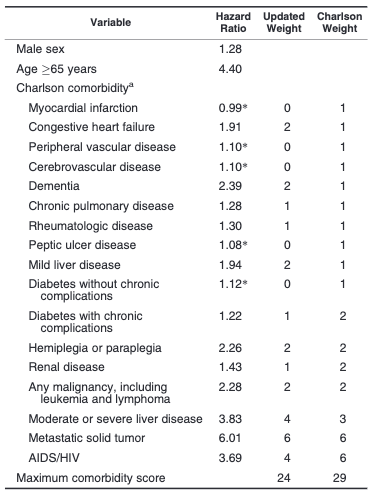

In [ ]:
cci_mapping = pd.read_csv('cci_snomed_ct_concepts.tsv', sep='\t', encoding='cp1252')

In [ ]:
cci_mapping['Comorbid Condition'].unique()

In [ ]:
cci_weights = {
    'Myocardial infarction': 1,
    'Congestive heart failure': 1, 
    'Peripheral vascular disease': 1,
    'Cerebrovascular disease': 1,
    'Dementia': 1,
    'Chronic pulmonary disease': 1,
    'Rheumatic disease': 1,
    'Peptic ulcer disease': 1,
    'Mild liver disease': 1,
    'Diabetes, without chronic complications': 1,
    'Diabetes, with chronic complications': 2,
    'Hemiplegia or paraplegia': 2,
    'Renal disease': 2,
    'Malignancy, except skin neoplasms': 2,
    'Moderate or severe liver disease': 3,
    'Metastatic solid tumor': 6,
    'AIDS/HIV': 6
}

In [ ]:
# Add weights to mapping
cci_mapping['weight'] = cci_mapping['Comorbid Condition'].map(cci_weights)

In [ ]:
concept_id_str = ','.join(map(str, cci_mapping['Concept ID']))
concept_code_str = "'" + "','".join(map(str, cci_mapping['Concept Code'])) + "'"

In [ ]:
# FYI, adding concept_code_str did not change number of detected rows
snomed_concepts_query = f"""
    (
        SELECT DISTINCT
            c.concept_code AS concept_code_sql,
            c.concept_name AS concept_name_sql,
            co.condition_concept_id AS concept_id
        FROM
            {version}.condition_occurrence AS co
        INNER JOIN
            {version}.concept AS c
        ON
            co.condition_concept_id = c.concept_id
        WHERE
            (c.vocabulary_id in ("SNOMED")
            AND c.concept_id IN ({concept_id_str}))
    )
    UNION DISTINCT
    (
        SELECT DISTINCT
            c.concept_code AS concept_code_sql,
            c.concept_name AS concept_name_sql,
            o.observation_concept_id AS concept_id
        FROM
            {version}.observation AS o
        INNER JOIN
            {version}.concept as c
        ON
            o.observation_concept_id = c.concept_id
        WHERE
            (c.vocabulary_id in ("SNOMED")
            AND c.concept_id IN ({concept_id_str}))
    )
"""

snomed_concepts_df = polars_gbq(snomed_concepts_query)

In [ ]:
cci_mapping_check = cci_mapping.merge(
    snomed_concepts_df.to_pandas(),
    left_on='Concept ID',
    right_on='concept_id',
    how='left'
)

In [ ]:
unmatched_cci = cci_mapping_check[cci_mapping_check['concept_code_sql'].isna()]

In [ ]:
cci_mapping[cci_mapping['Concept ID']==442144]

In [ ]:
# check of every 20th item in Data Browser revealed no entries
unmatched_cci[::20]

In [ ]:
snomed_events_query = f"""
    (
        SELECT DISTINCT
            co.person_id,
            co.condition_start_date AS date,
            c.concept_code AS concept_code,
            c.concept_name AS concept_name,
            co.condition_concept_id AS concept_id
        FROM
            {version}.condition_occurrence AS co
        INNER JOIN
            {version}.concept AS c
        ON
            co.condition_concept_id = c.concept_id
        WHERE
            (c.vocabulary_id in ("SNOMED")
            AND c.concept_id IN ({concept_id_str}))
    )
    UNION DISTINCT
    (
        SELECT DISTINCT
            o.person_id,
            o.observation_date AS date,
            c.concept_code AS concept_code,
            c.concept_name AS concept_name,
            o.observation_concept_id AS concept_id
        FROM
            {version}.observation AS o
        INNER JOIN
            {version}.concept as c
        ON
            o.observation_concept_id = c.concept_id
        WHERE
            (c.vocabulary_id in ("SNOMED")
            AND c.concept_id IN ({concept_id_str}))
    )
"""

snomed_events_df = polars_gbq(snomed_query)

In [ ]:
snomed_events_pd = snomed_events_df.to_pandas().merge(
    cci_mapping[['Concept ID', 'Comorbid Condition', 'weight']],
    right_on='Concept ID',
    left_on='concept_id',
    how='left'
).drop(columns=['Concept ID'])

In [ ]:
len(snomed_events_pd[snomed_events_pd['weight'].isna()])

In [ ]:
def calculate_cci_vectorized(df, snomed_events_pd):
    """Vectorized approach - much faster for large datasets"""
    
    # Get all person-time pairs
    person_time_df = df[['person_id', 'time_zero']].copy()
    
    # Merge with SNOMED events
    merged = person_time_df.merge(
        snomed_events_pd[snomed_events_pd['weight'].notna()],
        on='person_id',
        how='left'
    )
    
    # Filter for events before time_zero (handle timezone mismatch)
    merged = merged[merged['date'] < merged['time_zero']]
    
    # Group by person, time_zero, and condition - take max weight per condition
    condition_weights = (merged
                        .groupby(['person_id', 'time_zero', 'Comorbid Condition'])['weight']
                        .max()
                        .reset_index())
    
    # Sum weights across conditions for each person-time pair
    cci_scores = (condition_weights
                 .groupby(['person_id', 'time_zero'])['weight']
                 .sum()
                 .reset_index()
                 .rename(columns={'weight': 'cci_score'}))
    
    # Merge back to original dataframe
    result = df.merge(cci_scores, on=['person_id', 'time_zero'], how='left')
    result['cci_score'] = result['cci_score'].fillna(0)
    
    return result

In [ ]:
# Apply to all dataframes
final_df_with_cci = []

for i, df in enumerate(final_df):
    print(f"Processing dataframe {i}: {len(df)} rows")
    df_with_cci = calculate_cci_vectorized(df, snomed_events_pd)
    final_df_with_cci.append(df_with_cci)
    
    # Quick validation
    print(f"  CCI scores - Min: {df_with_cci['cci_score'].min()}, "
          f"Max: {df_with_cci['cci_score'].max()}, "
          f"Mean: {df_with_cci['cci_score'].mean():.2f}")
    
final_df = final_df_with_cci

In [ ]:
# Detailed validation for one dataframe
test_df = final_df[7]
# Check a specific person's calculation manually
sample_person = test_df['person_id'].iloc[17]
sample_time = test_df['time_zero'].iloc[17]

print(f"\nManual check for person {sample_person}, time_zero {sample_time}:")
person_conditions = snomed_events_pd[
    (snomed_events_pd['person_id'] == sample_person) &
    (snomed_events_pd['date'] < sample_time)
]['Comorbid Condition'].value_counts()
print(person_conditions)

In [ ]:
final_df[7][final_df[7]['person_id']==1000095]

In [ ]:
def calculate_cci_vectorized_demographics(df, snomed_events_pd):
    """Vectorized approach - much faster for large datasets"""
    
    # Get all person-time pairs
    person_time_df = df[['person_id']].copy()
    
    # Merge with SNOMED events
    merged = person_time_df.merge(
        snomed_events_pd[snomed_events_pd['weight'].notna()],
        on='person_id',
        how='left'
    )
        
    # Group by person, time_zero, and condition - take max weight per condition
    condition_weights = (merged
                        .groupby(['person_id', 'Comorbid Condition'])['weight']
                        .max()
                        .reset_index())
    
    # Sum weights across conditions for each person-time pair
    cci_scores = (condition_weights
                 .groupby(['person_id'])['weight']
                 .sum()
                 .reset_index()
                 .rename(columns={'weight': 'cci_score'}))
    
    # Merge back to original dataframe
    result = df.merge(cci_scores, on=['person_id'], how='left')
    result['cci_score'] = result['cci_score'].fillna(0)
    
    return result

In [ ]:
print(f"demographics_df: {len(demographics_df)} rows")
demographics_df = calculate_cci_vectorized_demographics(demographics_df, snomed_events_pd)

# Quick validation
print(f"  CCI scores - Min: {demographics_df['cci_score'].min()}, "
      f"Max: {demographics_df['cci_score'].max()}, "
      f"Mean: {demographics_df['cci_score'].mean():.2f}")

## Demographics Table

In [ ]:
def update_covariates(df, time_zero=False):
    if time_zero:
        date_cols = ['time_zero', 'dob']
        df[date_cols] = df[date_cols].apply(pd.to_datetime)

        # Calculate age in years from 'dob' to 'time_zero' and categorize it
        df['age'] = ((df['time_zero'].dt.tz_localize(None) - df['dob'].dt.tz_localize(None)) / pd.Timedelta(days=365.25)).astype(int)
    else:
        df['age'] = df['end_of_study_age']

    age_bins = [17, 24, 34, 44, 54, 64, 74, float('inf')]
    age_labels = ['17_24', '25_34', '35_44', '45_54', '55_64', '65_74', '75_plus']

    # Create binary columns for each age group
    for i, label in enumerate(age_labels):
        df[label] = ((df['age'] >= age_bins[i]) & (df['age'] < age_bins[i + 1])).astype(int)

    # Handling sex_at_birth with specified conditions
    conditions_sex = {'Female': 1, 'Male': 0, 'NoMatch': -9, 'Skip': -9, 'PNA': -9, 'Intersex': -9}
    df['female'] = df['sex_at_birth'].map(conditions_sex).fillna(-9)
    
    # Race
    df['black'] = (df['race'] == 'Black').astype(int)
    df['asian'] = (df['race'] == 'Asian').astype(int)
    df['nhpi'] = (df['race'] == 'NHPI').astype(int)
    df['multip'] = (df['race'] == 'Multip').astype(int)
    df['white'] = (df['race'] == 'White').astype(int)
    df['mena'] = (df['race'] == 'MENA').astype(int)
    df['aian'] = (df['race'] == 'AIAN').astype(int)
    df['race_none'] = (df['race'] == 'None').astype(int)
    df['race_NoInd'] = (df['race'] == 'NoInd').astype(int)
    df['race_skip'] = ((df['race'] == 'Skip') | (df['race'] == 'PNA')).astype(int)

    # Ethnicity
    df['hispanic'] = (df['ethnicity'] == 'HispLat').astype(int)
    df['not_hispanic'] = (df['ethnicity'] == 'NotHisp').astype(int)
    df['ethnicity_none'] = ((df['ethnicity'] == 'None') | (df['ethnicity'] == 'NoMatch')).astype(int)
    df['ethnicity_skip'] = ((df['ethnicity'] == 'Skip') | (df['ethnicity'] == 'PNA')).astype(int)

    # Employment
    df['employed'] = (df['employ'] == 'employed').astype(int)
    df['student'] = (df['employ'] == 'student').astype(int)
    df['homemaker'] = (df['employ'] == 'homemaker').astype(int)
    df['retired'] = (df['employ'] == 'retired').astype(int)
    df['out_of_work'] = (df['employ'] == 'out of work').astype(int)
    df['disabled'] = (df['employ'] == 'disabled').astype(int)
    df['emp_skip'] = (df['employ'] == 'unk_skip').astype(int)

    # Income
    df['less_25'] = ((df['income'] == 'less_10') | (df['income'] == '10_25')).astype(int)
    df['25_100'] = ((df['income'] == '25_35') | (df['income'] == '35_50') | (df['income'] == '50_75') | (df['income'] == '75_100')).astype(int)
    df['100_more'] = ((df['income'] == '100_150') | (df['income'] == '150_200') | (df['income'] == '200_more')).astype(int)
    df['inc_skip'] = (df['income'] == 'skip').astype(int)

    # Education
    df['edu_none'] = (df['edu'] == 'none').astype(int)
    df['k_12'] = ((df['edu'] == '1_4') | (df['edu'] == '5_8') | (df['edu'] == '9_11') | (df['edu'] == '12_GED')).astype(int)
    df['coll_1_3'] = (df['edu'] == 'coll_1_3').astype(int)
    df['coll_grad'] = (df['edu'] == 'coll_grad').astype(int)
    df['adv_degree'] = (df['edu'] == 'adv_degree').astype(int)
    df['edu_skip'] = (df['edu'] == 'skip').astype(int)

    # Insurance type
    df['medicaid'] = (df['ins_type'] == 'medicaid').astype(int)
    df['medicare'] = (df['ins_type'] == 'medicare').astype(int)
    df['emp'] = (df['ins_type'] == 'emp').astype(int)
    df['none'] = (df['ins_type'] == 'none').astype(int)
    df['other'] = ((df['ins_type'] == 'ihs') | (df['ins_type'] == 'purchased other') | (df['ins_type'] == 'military') | (df['ins_type'] == 'va')).astype(int)
    df['ins_skip'] = (df['ins_type'] == '-9').astype(int)

    return df

# Apply the function to each DataFrame in the list
final_df = [update_covariates(df, time_zero=True) for df in final_df]
demographics_df = update_covariates(demographics_df)

In [ ]:
def describe_group(df):
    """
    Generate descriptive statistics for a group within the DataFrame.
    """
    def custom_format(x):
        return f"{x:.1f}".rstrip('0').rstrip('.') if not pd.isna(x) else "NaN"

    # Descriptive statistics for continuous variables
    age_desc = df['age'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).map(custom_format)
    cci_desc = df['cci_score'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).map(custom_format)
    
    # Count and percentages for categorical variables
    def calc_percentage(col):
        valid_data = df[col][df[col] != -9]
        count = valid_data.sum()
        total = valid_data.count()
        perc = np.round(count / total * 100, 1) if total != 0 else 0
        
        # Handle small counts
        if 1 <= count < 20:
            count_str = "< 20"
            perc_str = f"< {np.round(20/total * 100, 1)}"
        else:
            count_str = str(count)
            perc_str = custom_format(perc)

        # Only include total if different from df length
        output = f"{count_str} ({perc_str})" if total == len(df) else f"{count_str}/{total} ({perc_str})"
        return output

    # Applying calc_percentage to various columns
    demographics_percentages = {col: calc_percentage(col) for col in ['female', 'white', 'race_skip', 'black', 
                                                                      'asian', 'multip', 'mena', 'aian', 'nhpi', 
                                                                      'race_none', 'race_NoInd', 'hispanic']}

    # Applying calc_percentage to various columns
    ses_percentages = {col: calc_percentage(col) for col in ['employed', 'retired', 'disabled', 'student', 'homemaker', 'out_of_work', 
                                                             'emp_skip', 'less_25', '25_100', '100_more', 'inc_skip', 'edu_none', 'k_12',
                                                             'coll_1_3', 'coll_grad', 'adv_degree', 'edu_skip', 'medicare', 
                                                             'medicaid', 'emp', 'none', 'other', 'ins_skip']}
        
    # Building the results dictionary
    results = {
        'Total': len(df),
        'Age, median (IQR)': f"{age_desc['median']} ({age_desc.iloc[1]}, {age_desc.iloc[2]})",
        'CCI, median (IQR)': f"{cci_desc['median']} ({cci_desc.iloc[1]}, {cci_desc.iloc[2]})",
        **{f"{key.capitalize()} (n (%))": value for key, value in demographics_percentages.items()},
        **{f"{key.capitalize()} (n (%))": value for key, value in ses_percentages.items()}

    }        

    return pd.DataFrame(results, index=[0])

def create_table_1(dfs, df_names, demographics_df):
    """
    Generate a comprehensive Table 1 for multiple DataFrames categorized by hospitalization status.
    """
    total_ehr_cohort = describe_group(demographics_df)
    summary_tables = []
    
    for df, name in zip(dfs, df_names):
        # Filtering groups within each DataFrame
        total = describe_group(df[(df['case'] == 0) | (df['case'] == 1)])
        episodes = describe_group(df[df['case'] == 1])
        
        # Combining the two groups
        combined = pd.concat([total, episodes], keys=[f'{name} Tested', f'{name} Episodes'])
        summary_tables.append(combined)

    # First concatenate all summary tables
    all_summaries = pd.concat(summary_tables)
    
    # Then concatenate with total_ehr_cohort using a single-level index
    final_summary = pd.concat([
        pd.DataFrame(total_ehr_cohort).assign(category='Total Cohort'),
        pd.DataFrame(all_summaries).assign(category='')
    ]).set_index('category', append=True)
        
    return final_summary     

table_1 = ''
table_1 = create_table_1(final_df, df_names, demographics_df)

In [ ]:
transposed_table = table_1.transpose()
transposed_table

# Save Phenotype

In [ ]:
# Assign names to DataFrames
for i, df in enumerate(final_df):
    df.name = df_names[i]

In [ ]:
print(subprocess.check_output(f"gsutil ls -r {my_bucket}/data/", shell=True).decode('utf-8'))

In [ ]:
# Removing all files within /data/filtered_cohorts/
subprocess.run(f"gsutil rm {my_bucket}/data/filtered_cohorts/*", shell=True)

In [ ]:
for df in final_df:
    # Construct the destination filename using the DataFrame's name
    destination_filename = df.name + "_full_demographics.csv"  # Assuming DataFrame has a 'name' attribute

    # save dataframe in a csv file in the same workspace as the notebook
    df.to_csv(f"{my_bucket}/data/filtered_cohorts/{destination_filename}", index=False)

In [ ]:
# Save df subsets
for i, df in enumerate(final_df):
    df = df[['person_id', 'time_zero', 'case', 'age', 'race', 'ethnicity', 'sex_at_birth', 'max_acuity']]
    df.name = df_names[i]

    # Construct the destination filename using the DataFrame's name
    destination_filename = df.name + ".csv"  # Assuming DataFrame has a 'name' attribute

    # save dataframe in a csv file in the same workspace as the notebook
    df.to_csv(f"{my_bucket}/data/filtered_cohorts/{destination_filename}", index=False)